<a href="https://colab.research.google.com/github/Shruthi-GS/brailleTranslate/blob/main/BrailleTranslator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DIP Assignment 1:**
Decoding Braille Langue Images using Connected Component Labeling and Image Processing
Fundamentals bold text
*   Name:    Zakriya Asif Paracha
*   Regn no: 340413
*   dept:    CE42B

To use the code you need to upload following files:
1.   Braille.png
2.   Conversiontable.json





In [64]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random
import copy
import json
from google.colab.patches import cv2_imshow

In [65]:
#------ main function
def CCA8(image, vset):
    #inputs: nparray:image, list: vset
    #Outputs: (count,map,stats[label: (x_i, y_i, x_m, y_m)])
    #replacement dictionary

    #-- helping functions to keep track of positions of the objects
    tobedeleted= set()
    def updatestats(label,i,j):
        #mantain the maximum pixels for each image
        stats[label]['x_min']=min(stats[label]['x_min'], i)
        stats[label]['y_min']=min(stats[label]['y_min'], j)
        stats[label]['max_x']=max(stats[label]['max_x'], i)
        stats[label]['max_y']=max(stats[label]['max_y'], j)

        if(label!=1):
            #mantaining bigest length
            diffx=stats[label]['max_x']-stats[label]['x_min']
            diffy=stats[label]['max_y']-stats[label]['y_min']
            if(diffx>stats['max_lenx']):stats['max_lenx']= diffx
            if(diffy>stats['max_leny']):stats['max_leny']= diffy
        return stats

    def mergestats(label2,label):
        #mantain the maximum pixels for each image
        stats[label]['x_min']=min(stats[label]['x_min'], stats[label2]['x_min'])
        stats[label]['y_min']=min(stats[label]['y_min'], stats[label2]['y_min'])
        stats[label]['max_x']=max(stats[label]['max_x'], stats[label2]['max_x'])
        stats[label]['max_y']=max(stats[label]['max_y'], stats[label2]['max_y'])
        tobedeleted.add(label2)

        if(label!=1):
            #mantaining bigest length
            diffx=stats[label]['max_x']-stats[label]['x_min']
            diffy=stats[label]['max_y']-stats[label]['y_min']
            if(diffx>stats['max_lenx']):stats['max_lenx']= diffx
            if(diffy>stats['max_leny']):stats['max_leny']= diffy
        return stats

    #-- replace dictionary
    rd= {}
    #-- padding the image top and bottom
    paddedImg=cv2.copyMakeBorder(image,1,0,1,1,cv2.BORDER_CONSTANT)
    #--return an objects map
    objectMap=np.zeros((paddedImg.shape[0],paddedImg.shape[1]), dtype=np.int32)
    height,width=paddedImg.shape
    #-- mainAlgorithm
    stats={'max_lenx':0,'max_leny':0}
    labelcount=0
    for i in range(height):
        for j in range(width-1):
            if(paddedImg[i][j] in vset):
                neighbours=[objectMap[i-1][j],objectMap[i][j-1],objectMap[i-1][j-1],objectMap[i-1][j+1]]

                #--if all are zero
                if(neighbours.count(0)==4):
                    labelcount+=1
                    objectMap[i][j]=labelcount
                    stats[labelcount]={'x_min': i, 'y_min': j,'max_x': i, 'max_y': j}

                #--if less then 3 are zero
                else:
                    minimum= min([i for i in neighbours if i!= 0]) #ignore zeros
                    neighbours_reduced= [i for i in neighbours if i!= minimum and i!=0] #ignore minimums

                    #-- assign minimun to all the left values in rd
                    objectMap[i][j]= minimum
                    stats= updatestats(minimum,i,j)
                    if(minimum in rd):
                        for nr in neighbours_reduced:
                            rd[nr]=rd[minimum]

                    else:
                        for nr in neighbours_reduced:
                            rd[nr]=minimum

    #-- replace the values using replacement dictionary and remove padding and count the objects
    for i in range(1,height):
         for j in range(1,width-1):
            if(objectMap[i][j] in rd.keys()):
                stats = mergestats(objectMap[i][j],rd[objectMap[i][j]])
                objectMap[i][j]=rd[objectMap[i][j]]

    #-- delete all the extra nodes
    for i in tobedeleted:
        del stats[i]

    #-- removing background data
    count=labelcount- len(rd) -1
    del stats[1]
    return(count,objectMap[1:-1,1:-1],stats) #count of objects , positions of the object

In [66]:
#------ helping functions
def boundingbox(img, stats):
    newimg= copy.deepcopy(img)
    for object in stats.values():
        if(type(object) is dict):
            newimg = cv2.rectangle(newimg, (object['y_min'],object['x_min']), (object['y_min']+stats['max_leny'],object['x_min']+stats['max_lenx']), (125), 2)
    return newimg

def color(img,basebrightness=50):
    #give Random color to each object in label table
    c_img= np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
    colordict={0:(0,0,0)}
    for i in range (img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] not in colordict):
                colordict[img[i][j]]=(random.randint(basebrightness,255),random.randint(basebrightness,255),random.randint(basebrightness,255))
            c_img[i][j]=colordict[img[i][j]]
    return c_img

def clustering(img_input,stats,threshold=200):
    """
    #cluster the pixels in the bounding box and convert it to array
    Internal encoding: in the image ,we move up to down and left to right. for example for C
    C=[[1,1]
       [0,0]
       [0,0]]
    so its representation would be '100100'
    """
    shapes=[]    #[strings]
    for stt in  stats.values():
        shape= ''

        if(type(stt) is dict):
            x_max,x_min,y_max,y_min= stt['x_min']+stats['max_lenx'],stt['x_min'] ,stt['y_min']+stats['max_leny'],stt['y_min']

            y_mid= (y_min+y_max)//2
            x_length= (x_max-x_min)//3
            x_lowermid=x_min+ x_length
            x_uppermid=x_min+(2*x_length)

            #-- devide the image in 6 subsections
            shape +=str(int((img_input[ x_min      :x_lowermid   ,y_min:y_mid]==0).sum()>threshold))
            shape +=str(int((img_input[x_lowermid  :x_uppermid    ,y_min:y_mid]==0).sum()>threshold))
            shape +=str(int((img_input[x_uppermid  :x_max         ,y_min:y_mid]==0).sum()>threshold))
            shape +=str(int((img_input[ x_min      :x_lowermid   ,y_mid:y_max]==0).sum()>threshold))
            shape +=str(int((img_input[x_lowermid  :x_uppermid    ,y_mid:y_max]==0).sum()>threshold))
            shape +=str(int((img_input[x_uppermid  :x_max         ,y_mid:y_max] ==0).sum()>threshold))
            shapes.append(shape)
    return shapes

def managespaces(image, stats,threshold):
#calculate the indexes of the spaces in text
    k=list(stats.keys())
    s=[]
    for i in range(2,len(k)-1):
        sd=abs(stats[k[i+1]]['y_min'] - stats[k[i]]['max_y'])
        if (sd>threshold):s.append(i-1)
    return s

def mergetext(inp, spaces):
#join the text with the spaces
    text=inp
    added_spaces= 0
    for i in spaces:
            text=text[:i+added_spaces]+' '+text[i+added_spaces:]
            added_spaces+=1
    return text

Depending on the imagesize, braille cell size and dimentions these parameters would needed to be changed
for the given input: if you want to make the Convertion table True the "makingkey".

In [82]:
#parameters
makingkey = False                              #key: True     ,actualimage:false
if (makingkey):
  GaussianBlur = (3,3)                         #key: (3,3)   , actualimage: (1,1)
  kernelerode = np.ones((17,5), np.uint8)      #key:   , actualimage: (17,5)
  prevresolution= (600,350)                    #key:(600,350)    , actualimage:(720,1080)
  clusteringthreshold = 200                     #key: 200     , actualimage: 20
  filename = '/content/howAreYou.jpg'                   #key: 'processedKey.png' ,actualimage : 'braille.png'
  conversiontable='/content/data.json'
else:
  GaussianBlur = (1,1)                         #key: (3,3)   , actualimage: (1,1)
  kernelerode = np.ones((17,5), np.uint8)      #key, actualimage: (17,5)
  prevresolution= (720,1080)                    #key:(600,350)    , actualimage:(720,1080)
  clusteringthreshold = 29                     #key: 200     , actualimage: 20
  filename = '/content/howAreYou.jpg'                   #key: 'processedKey.png' ,actualimage : 'braille.png'
  conversiontable='/content/data.json'
  outputfile= '/content/translated.txt'


InputShape (919, 1020)


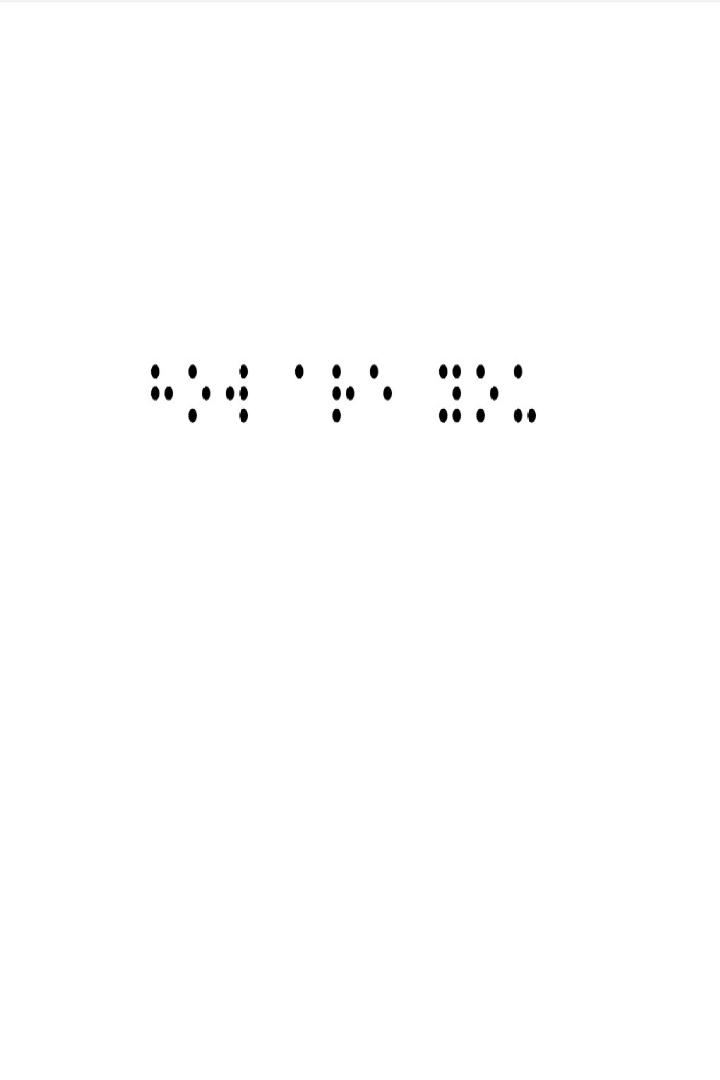

In [83]:
#------ input image and pre processing- resize, blur
img_input = cv2.imread(filename,0) #load grayscale img
print("InputShape" ,img_input.shape)
cv2_imshow(cv2.resize(img_input, prevresolution, interpolation = cv2.INTER_AREA))

blured and thresholded 


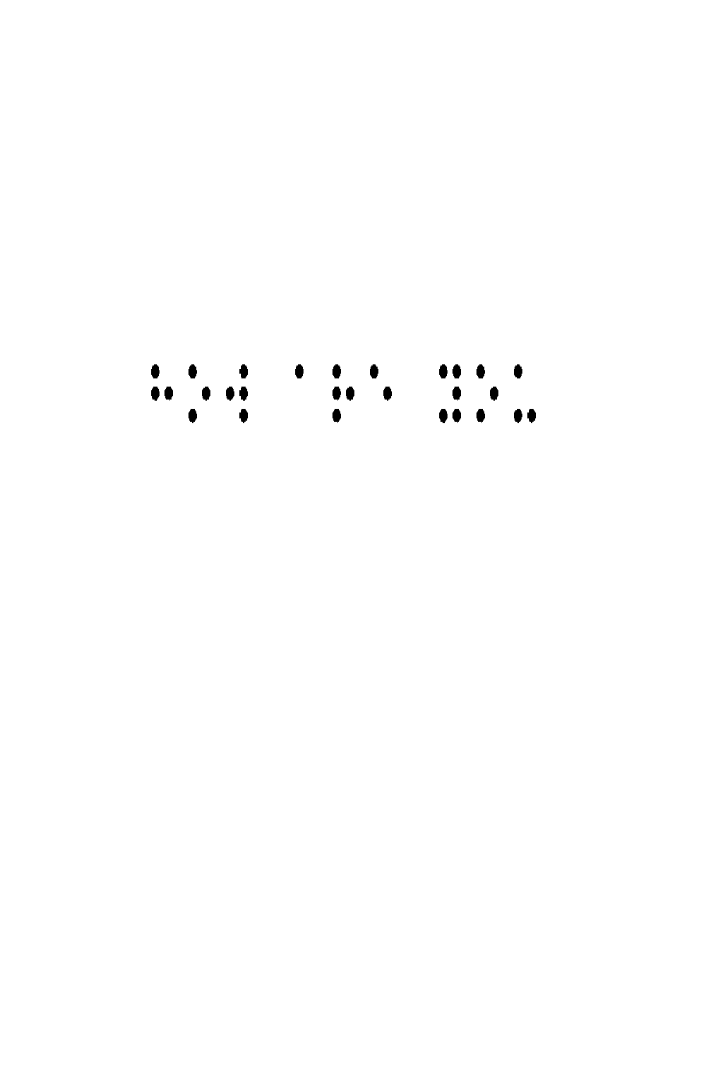

In [84]:
#------ preprocessing
blur_image = cv2.GaussianBlur(img_input,GaussianBlur,0) #blur the image
_,threshimage = cv2.threshold(blur_image,127,255,cv2.THRESH_BINARY)
print("blured and thresholded ")
cv2_imshow(cv2.resize(threshimage,prevresolution, interpolation = cv2.INTER_AREA))

**Erode:** Erode is a image processing tool which is used to spread/expand the pixels, which helps us in the given case to connect the braille cells with each oth

Eroded image 


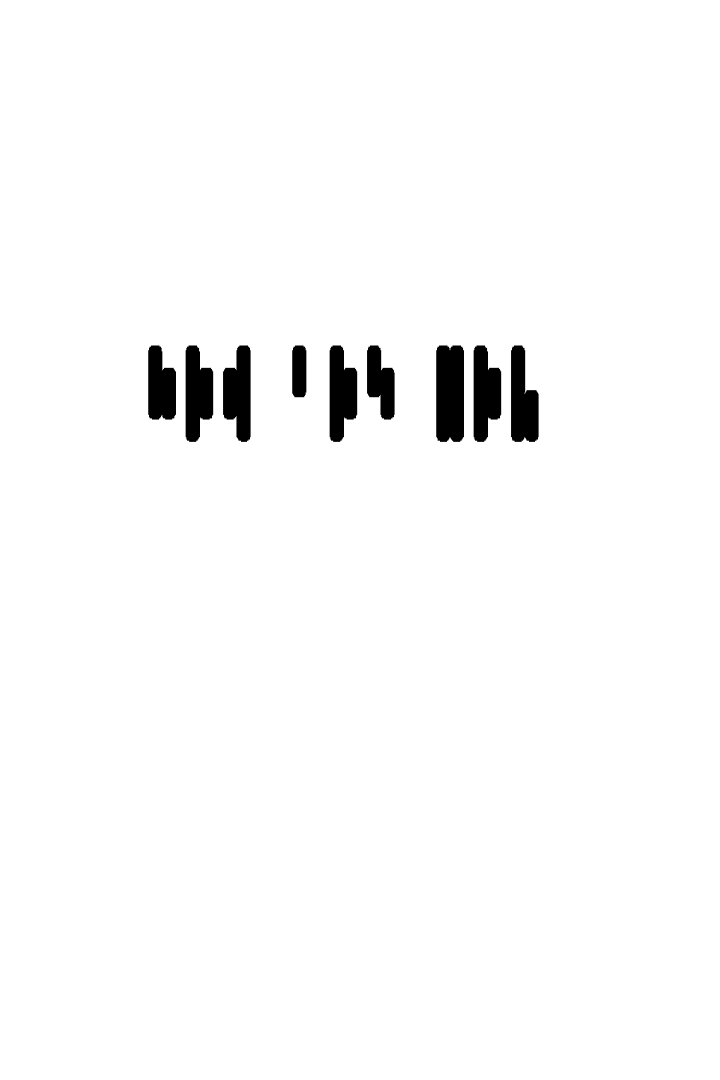

In [85]:
#------ erode the image
img_erode = cv2.erode(threshimage, kernelerode, iterations=2)
print("Eroded image ")
cv2_imshow(cv2.resize(img_erode, prevresolution, interpolation = cv2.INTER_AREA))


**CCA8:**
This function takes in the eroded image and do Connected component analysis on it.

Return:  
*   **Count:** Number of indendent objects in the image
*   **objects:** image with same dimetions as input image but, it marks each object with a specific label
*   **Stats:** it is used in processing on coming stages, it have the information about minimum and maximum of all the objects, and maxlenghth of an object and max width

**Color:** Its a simple procedure which inputs the objects image and give each object an specific color, for better visualization.


Charecters: 9


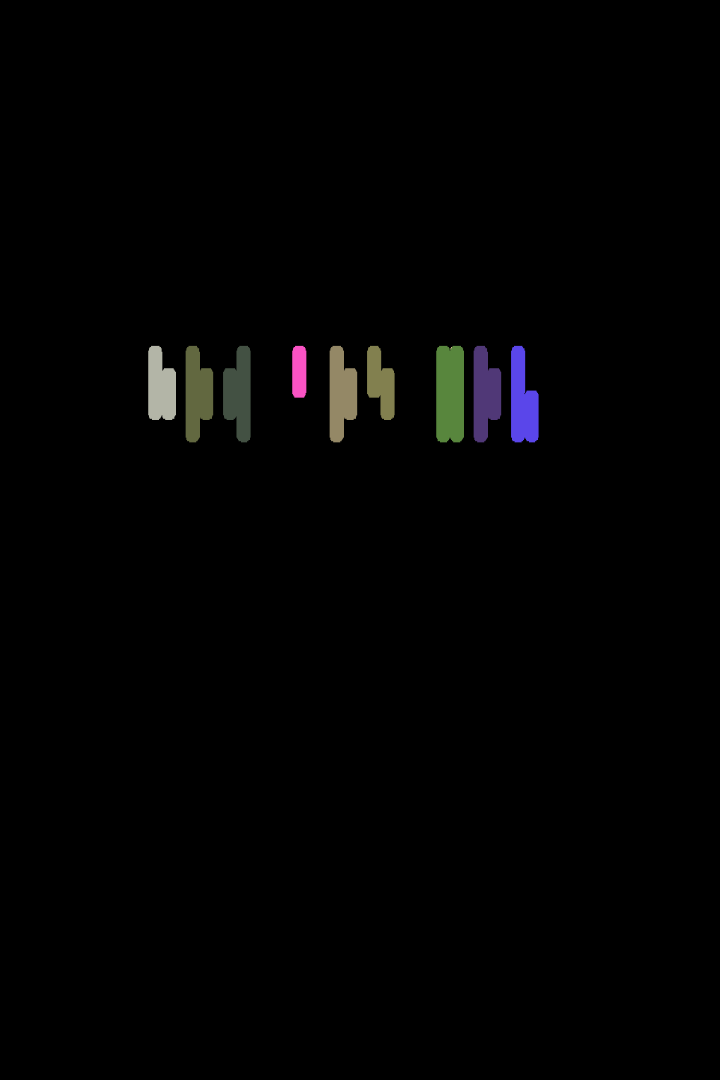

In [86]:
#------ get the obects from the image
#inefficient CCA8 algo, took about 2.5 minutes to run
vset=[0]
count,objects,stats=CCA8(img_erode,vset)   #count of objects , positions of the object,stats=initial and ending points ,maximum size object
print("Charecters:",count) #-1 for background
cv2_imshow(cv2.resize(color(objects), prevresolution, interpolation = cv2.INTER_AREA))

Using the Stats from last code block, we can analyze each charecter seprately, I have added bounding box, around them.
**clustring:**: It takes in information, stats and return string of charecters in the image.
**managespaces**: on the bases of X_axis distance between two consective objects, I calculate all the posible space indexes and return them.

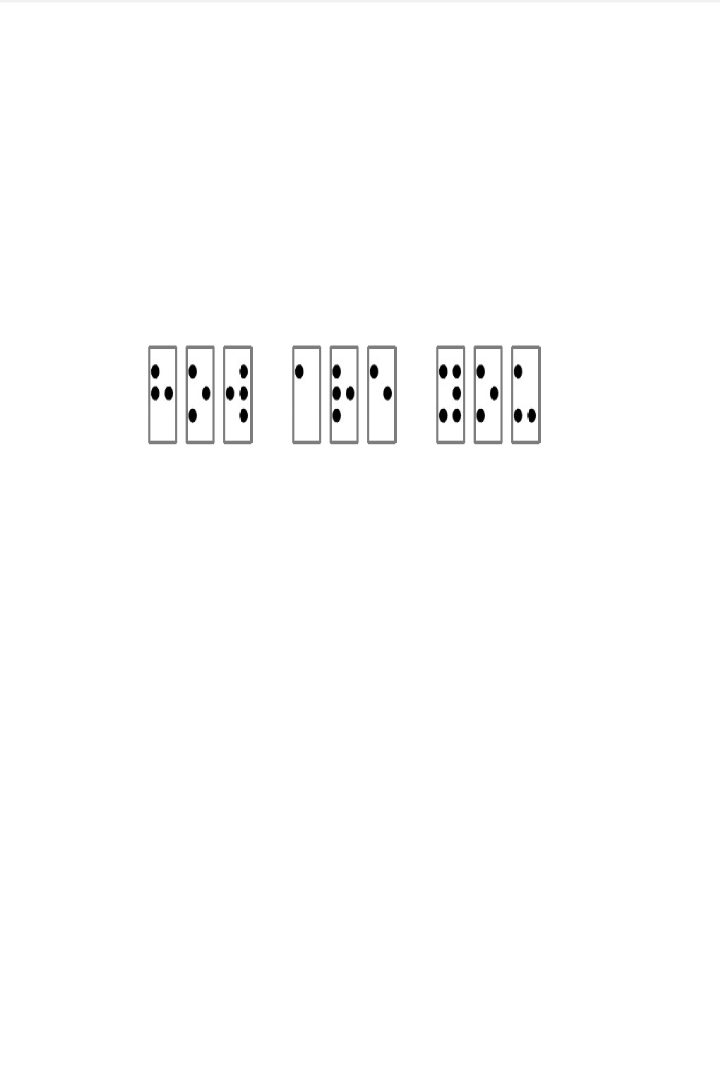

In [87]:
#------ drawing bounded boxex on each object
bounded = boundingbox(img_input,stats)
spacemap = managespaces(threshimage , stats,50) #spacebars and mapped image
chars=    clustering(threshimage,stats,clusteringthreshold)
cv2_imshow(cv2.resize(bounded, prevresolution, interpolation = cv2.INTER_AREA))


In [88]:
def makekey(fn, expectedstring, shapes):
    #store the array representation in json file
    expectedstring=expectedstring.replace(' ', '') #remove extra spaces
    char_to_arr={}
    for i,v in enumerate(expectedstring):
        char_to_arr[shapes[i]]=v

    with open(fn, 'w') as convert_file:
        convert_file.write(json.dumps(char_to_arr))
    return char_to_arr

#------ Make the key  #note: use the processed key rather then actual key
if(makingkey):
    knowntext = 'abcdefghijklmnopqrstuvwxyz'
    makekey('conversiontable.json',knowntext,chars)

In [89]:
#from 3x2 array -> charecter
def translate(fn,shapes):
    converstionkeys = json.load(open(fn,"r"))
    message_str=''
    for i in shapes:
        message_str += converstionkeys[i]

    return message_str

#------ Use key to translate
if(not(makingkey)):
    text = translate('/content/data.json',chars)
    finaltext=mergetext(text,spacemap)
    print("FINAL TEXT: ",finaltext)
    #writing the output to the file
    with open(outputfile, 'w') as f:
        f.write(finaltext)

FINAL TEXT:  how are you
